In [86]:
import numpy as np
import import_ipynb
from NN import get_dataset, get_model, get_shape, set_shape, get_con_mat
from keras.losses import BinaryCrossentropy
from tensorflow import cast, int32
from scipy import integrate
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.stats import cauchy
from sklearn.metrics import confusion_matrix

In [2]:
best_callBack = np.asarray([])

In [3]:
def truncated_cauchy(mean, std, lower=0., upper=1.0):
    x = cauchy.rvs(mean,std)
    if x > upper:
        x = 1.0
        return x
    elif x < lower:
        return truncated_cauchy(mean,std)
    else:
        return x

def lehmer_mean(lst):
    if len(lst) == 0:
        return 0
    
    numerator = np.sum(np.power(lst, 2))
    denominator = np.sum(lst)
    return numerator/denominator

def inverse_probability(epsilon, x_0, x_min, x_max):
    y = np.random.random(len(x_min))
    a = (x_max - x_0) / epsilon
    b = (x_min - x_0) / epsilon
    return epsilon * np.tan(y * np.arctan(a) + (1.0 - y) * np.arctan(b)) + x_0

In [45]:
def SoFA( fitFunction, bounds, scbd = 0.01, initial_population_size = 100, max_iter = 10000
         , verbose = True,mu_mean=0.5,c=0.5,eps_len=300, eps_hbound=1.2):
    points = [np.random.uniform(bounds[:, 0],bounds[:, 1],len(bounds)) for i in range(initial_population_size)]
    fitnesses = np.asarray([fitFunction(_) for _ in points])
    fittestValue = np.max(fitnesses)
    worestValue = np.min(fitnesses)
    fittestPoint = points[np.argmax(fitnesses)]
    width = fittestValue - worestValue
    numerator = ((fitnesses-worestValue) / width) ** len(fitnesses)
    denominator = np.sum(numerator)
    probabilities = numerator / denominator
    probabilities = np.absolute(probabilities)
    eps_mean = mu_mean
    counter = 0
    gen_counter = 0
    S_epses = []
    LossHistory = list()
    while(counter < max_iter):
        counter +=1
        epsilon = truncated_cauchy(eps_mean,0.1)
        index = np.random.choice(len(points), p=probabilities)
        newPoint = inverse_probability(epsilon, points[index], bounds[:, 0], bounds[:, 1])
        newFitness = fitFunction(newPoint)
        if newFitness > fitnesses[index]:
            S_epses.append(epsilon)
        points.append(newPoint) 
        fitnesses = np.insert(fitnesses,len(fitnesses),newFitness)
        if newFitness > fittestValue :
            fittestPoint = newPoint
            best_callBack = newPoint
            fittestValue = newFitness
            if verbose:
                print("iteration %d : %f mu_mean = %f epsilon = %f" % (counter, -fittestValue, eps_mean , epsilon))
        elif newFitness < worestValue :
            worestValue = newFitness
        LossHistory.append(fittestValue)
        width = fittestValue - worestValue
        numerator = ((fitnesses-worestValue) / width) ** len(fitnesses)
        denominator = np.sum(numerator)
        probabilities = numerator / denominator
        probabilities = np.absolute(probabilities)
        if gen_counter == eps_len-1:
            eps_mean = (1-c)*eps_mean + c*lehmer_mean(S_epses)
            S_epses = []
            gen_counter = 0
        else:
            gen_counter +=1
    return [fittestPoint, fittestValue, LossHistory]

In [31]:
X_train, X_test, y_train, y_test = get_dataset()

In [32]:
model = get_model()
model.compile(loss = 'binary_crossentropy', metrics=['accuracy'])

In [33]:
shapes = get_shape(model)

In [34]:
def loss_fun(weights) :
    model.set_weights(set_shape(weights, shapes))
    loss = BinaryCrossentropy()
    predictions =  model(X_train, training=True).numpy().flatten()
    value = loss(y_train, predictions).numpy()
    return -value

In [35]:
def get_con_mat(model,X,Y):
    y_pred = model.predict(X_test)
    y_pred_binary = cast(y_pred > 0.5, dtype=int32).numpy()
    con_1 = confusion_matrix(Y, y_pred_binary)
    plt.style.use('seaborn-deep')
    plt.figure(figsize=(5,5))
    sns.heatmap(con_1,annot=True,annot_kws={'size': 15},linewidths=0.5,fmt="d",cmap="Blues")
    plt.title('Churn confusion matrix\n',fontweight='bold',fontsize=15)
    plt.show()

In [36]:
limits = [0.522,0.1,0.522,0.1,0.707,0.1]

In [37]:
numbers = []
for shape in shapes:
    numbers.append(np.prod(shape))

In [38]:
max_=np.asarray([])
for i,j in zip(limits,numbers):
    temp = np.asarray([i for _ in range(j)])
    max_ = np.concatenate((max_, temp), axis=None)
min_= max_ * -1
bounds=np.asarray([(i,j) for i,j in zip(min_,max_)])

In [74]:
result=SoFA(loss_fun,bounds,mu_mean=0.5,c=0.7,eps_hbound=1.0, max_iter = 20000, eps_len=400)
model.set_weights(set_shape(result[0], shapes))
model.evaluate(X_test,y_test)

iteration 62 : 0.513353 mu_mean = 0.500000 epsilon = 0.026494
iteration 75 : 0.507034 mu_mean = 0.500000 epsilon = 0.488364
iteration 467 : 0.503283 mu_mean = 0.475217 epsilon = 0.088137
iteration 803 : 0.499906 mu_mean = 0.204261 epsilon = 0.091097
iteration 865 : 0.499431 mu_mean = 0.204261 epsilon = 0.015406
iteration 903 : 0.497942 mu_mean = 0.204261 epsilon = 0.153860
iteration 916 : 0.489996 mu_mean = 0.204261 epsilon = 0.081615
iteration 920 : 0.481106 mu_mean = 0.204261 epsilon = 0.219319
iteration 962 : 0.479222 mu_mean = 0.204261 epsilon = 0.009111
iteration 1067 : 0.478573 mu_mean = 0.204261 epsilon = 0.002263
iteration 1110 : 0.475465 mu_mean = 0.204261 epsilon = 0.010012
iteration 1258 : 0.474522 mu_mean = 0.164515 epsilon = 0.023641
iteration 1523 : 0.473713 mu_mean = 0.164515 epsilon = 0.057525
iteration 1665 : 0.472286 mu_mean = 0.079219 epsilon = 0.010269
iteration 1677 : 0.471009 mu_mean = 0.079219 epsilon = 0.062270
iteration 1699 : 0.470783 mu_mean = 0.079219 epsilo

[0.41157183051109314, 0.8065000176429749]

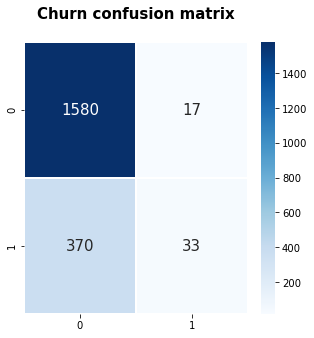

In [78]:
get_con_mat(model, X_test, y_test)

In [76]:
with open("sofa.json", "r") as f:
    my_list = json.load(f)

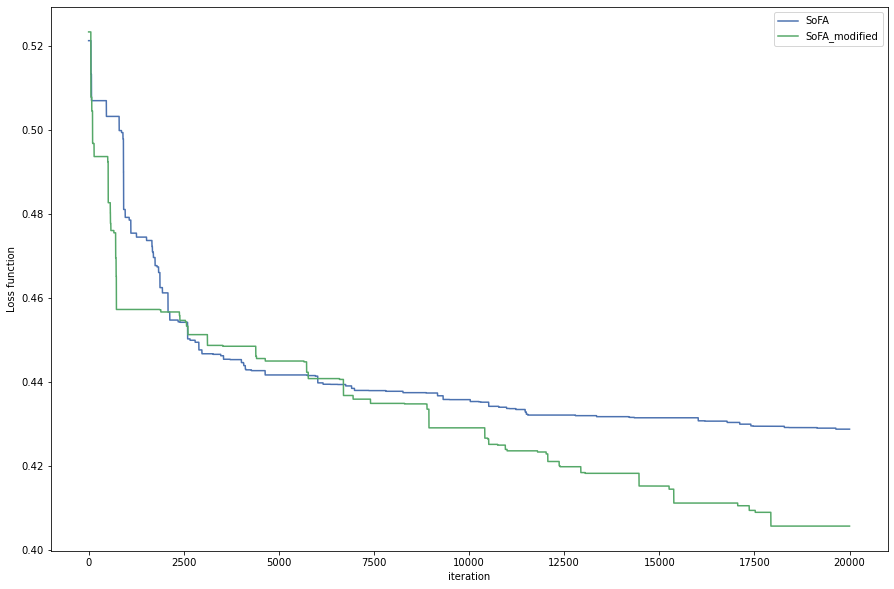

In [79]:
plotting = np.absolute(result[2])
plotting2 = np.absolute(my_list)
plt.figure(figsize=(15,10))
plt.plot(np.arange(20000),plotting, label="SoFA")
plt.plot(np.arange(20000),plotting2, label="SoFA_modified")
plt.xlabel("iteration")
plt.ylabel("Loss function")
plt.savefig('4.png')
plt.legend()
plt.show()

In [5]:
def obj(x):
    return -((x[0]+2*x[1]-7)**2+(2*x[0]+x[1]-5)**2)

In [6]:
bounds_ = np.asarray([(-10.0, 10.0), (-10.0, 10.0)])

In [27]:
obj_result=SoFA(obj,bounds_,mu_mean=0.6,eps_hbound=1.2,max_iter = 1000)
obj_result[0]

iteration 110 : 0.013097 mu_mean = 0.600000 epsilon = 0.598820
iteration 229 : 0.003609 mu_mean = 0.641713 epsilon = 1.000000


array([1.01459952, 3.01371887])

In [29]:
with open("obj.json", "r") as f:
    sofa_obj = json.load(f)
    

In [19]:
with open("de.json", "r") as f:
    de = json.load(f)

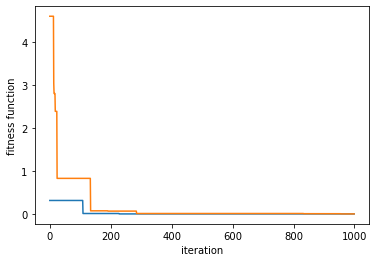

In [43]:
plotting_obj = np.absolute(obj_result[2])
plotting2_obj = np.absolute(sofa_obj)
plt.plot(np.arange(1000),plotting_obj)
plt.plot(np.arange(1000),plotting2_obj)
plt.xlabel("iteration")
plt.ylabel("fitness function")
plt.show()

In [218]:
mus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
soulutions = {}

In [176]:
for i in mus:
    for j in cs :
        result=SoFA(loss_fun,bounds,mu_mean=i,c=j,eps_hbound=1.0,verbose=False)
        model.set_weights(set_shape(result[0], shapes))
        score = model.evaluate(X_test,y_test, verbose = False)
        soulutions[str(i)+'/'+str(j)] = score[0]
        print(str(i)+'/'+str(j) + " = " + str(score[0]))

KeyboardInterrupt: 

In [223]:
x = [[i for i in range(1,10)] for j in range (10)]

In [224]:
np.mean(x)

5.0

In [98]:
y_pred = model.predict(X_test)
y_pred_binary = cast(y_pred > 0.5, dtype=int32).numpy()
con_1 = confusion_matrix(y_test, y_pred_binary)
con = np.asarray([[1536,   61],[ 260,  143]])

In [99]:
con = con = np.asarray([[1536,   61],[ 260,  143]])

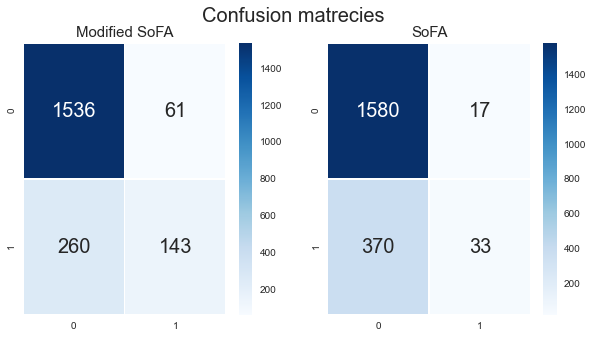

In [108]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

plt.style.use('seaborn')
sns.heatmap(con,ax=axs[0],annot=True,annot_kws={'size': 20},linewidths=0.5,fmt="d",cmap="Blues")
axs[0].set_title('Modified SoFA',fontsize=15)

plt.style.use('seaborn')
sns.heatmap(con_1,ax=axs[1],annot=True,annot_kws={'size': 20},linewidths=0.5,fmt="d",cmap="Blues")
axs[1].set_title('SoFA',fontsize=15)

fig.suptitle('Confusion matrecies',fontsize=20)
plt.savefig('5.png')
# Display the figures
plt.show()